# Initialization

Run the following code to import the modules you'll need. After your finish the assignment, **remember to run all cells** and save the note book to your local machine as a PDF for gradescope submission.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Download data

In this section we will download the data and setup the paths.


In [2]:
# Download the data
if not os.path.exists('/content/carseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/carseq.npy -O /content/carseq.npy
if not os.path.exists('/content/girlseq.npy'):
    !wget https://www.cs.cmu.edu/~deva/data/girlseq.npy -O /content/girlseq.npy

--2025-02-16 00:29:51--  https://www.cs.cmu.edu/~deva/data/carseq.npy
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254976128 (243M)
Saving to: ‘/content/carseq.npy’

/content/carseq.npy 100%[===================>] 243.16M   107KB/s    in 23m 10s 

2025-02-16 00:53:02 (179 KB/s) - ‘/content/carseq.npy’ saved [254976128/254976128]

--2025-02-16 00:53:02--  https://www.cs.cmu.edu/~deva/data/girlseq.npy
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27648128 (26M)
Saving to: ‘/content/girlseq.npy’

/content/girlseq.np 100%[===================>]  26.37M   592KB/s    in 48s     

2025-02-16 00:53:51 (560 KB/s) - ‘/content/girlseq.npy’ saved [27648128/27648128]



# Q2.1: Theory Questions (5 points)
Please refer to the handout for the detailed questions.

## Q2.1.1: What is $\frac{\partial \mathbf{W}(\mathbf{x};\mathbf{p})}{\partial \mathbf{p}^{T}}$? (**Hint**: It should be a 2x2 matrix)

===== your answer here! =====

The warp is a simple translation, each component of $\mathbf{W}$ is linear with respect to the corresponding parameter. Therefore, we have:
$$
\frac{\partial \mathbf{W}(\mathbf{x};\mathbf{p})}{\partial \mathbf{p}^{T}} =
\begin{bmatrix}
\frac{\partial (x + p_x)}{\partial p_x} & \frac{\partial (x + p_x)}{\partial p_y} \\
\frac{\partial (y + p_y)}{\partial p_x} & \frac{\partial (y + p_y)}{\partial p_y}
\end{bmatrix} =
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}.
$$


===== end of your answer =====

## Q2.1.2: What is $\mathbf{A}$ and $\mathbf{b}$?

===== your answer here! =====


**A:** The matrix $$A$$ is defined as the Jacobian (with respect to the parameters) of the image intensity at the warped coordinates. Formally,  

$$
A = \nabla I_{t+1}\big(\mathbf{W}(\mathbf{x}; \mathbf{p})\big) \cdot \frac{\partial \mathbf{W}(\mathbf{x}; \mathbf{p})}{\partial \mathbf{p}^{T}}.
$$  

Since  

$$
\frac{\partial \mathbf{W}(\mathbf{x}; \mathbf{p})}{\partial \mathbf{p}^{T}} = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix},
$$  

this simplifies to:  

$$
A = \nabla I_{t+1}\big(\mathbf{W}(\mathbf{x}; \mathbf{p})\big).
$$  

For a template containing $$D$$ pixels, $$A$$ is a $$D \times 2$$ matrix where each row corresponds to the spatial image gradients (in $$x$$ and $$y$$) evaluated at the warped positions:

$$
A = \begin{bmatrix}
\nabla I_{t+1}\big(\mathbf{W}(\mathbf{x}_1; \mathbf{p})\big) \\
\nabla I_{t+1}\big(\mathbf{W}(\mathbf{x}_2; \mathbf{p})\big) \\
\vdots \\
\nabla I_{t+1}\big(\mathbf{W}(\mathbf{x}_D; \mathbf{p})\big)
\end{bmatrix}.
$$

**b:** The vector $$b$$ represents the residual (or error) between the template $$T_t$$ and the warped image $$I_{t+1}$$ at the current estimate $$\mathbf{p}$$. It is given by:

$$
b = T_t(\mathbf{x}) - I_{t+1}\big(\mathbf{W}(\mathbf{x}; \mathbf{p})\big),
$$

where the subtraction is performed pixel-wise over all $$D$$ pixels in the template.

===== end of your answer =====

## Q2.1.3 What conditions must $\mathbf{A}^{T}\mathbf{A}$ meet so that a unique solution to $\Delta \mathbf{p}$ can be found?

===== your answer here! =====

In the least-squares formulation, we solve:

$$
\arg\min_{\Delta \mathbf{p}} \|A \Delta \mathbf{p} - b\|_2^2,
$$

which leads to the normal equations:

$$
A^T A \Delta \mathbf{p} = A^T b.
$$

A unique solution for $$\Delta \mathbf{p}$$ exists if and only if $$\mathbf{A}^{T}\mathbf{A}$$ is invertible. This requires that:

1. **Full Rank:** The matrix $$A$$ must have full column rank in this 2D case, meaning that its two columns (corresponding to the $$x$$ and $$y$$ gradients) are linearly independent.

2. **Positive Definiteness:** As a consequence, $$\mathbf{A}^{T}\mathbf{A}$$ is a $$2 \times 2$$ positive definite matrix, ensuring it is nonsingular. This means that the image patch must have sufficient texture or variation in intensity in both directions; otherwise, $$\mathbf{A}^{T}\mathbf{A}$$ may be singular.

===== end of your answer =====

# Q2.2: Lucas-Kanade (20 points)
Make sure to comment your code and use proper names for your variables.

In [3]:
from scipy.interpolate import RectBivariateSpline
from numpy.linalg import lstsq

def LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2)):
    """
    :param[np.array(H, W)] It   : Grayscale image at time t [float]
    :param[np.array(H, W)] It1  : Grayscale image at time t+1 [float]
    :param[np.array(4, 1)] rect : [x1 y1 x2 y2] coordinates of the rectangular template to extract from the image at time t,
                                  where [x1, y1] is the top-left, and [x2, y2] is the bottom-right. Note that coordinates
                                  [floats] that maybe fractional.
    :param[float] threshold     : If change in parameters is less than thresh, terminate the optimization
    :param[int] num_iters       : Maximum number of optimization iterations
    :param[np.array(2, 1)] p0   : Initial translation parameters [p_x0, p_y0] to add to rect, which defaults to [0 0]
    :return[np.array(2, 1)] p   : Final translation parameters [p_x, p_y]
    """

    # Initialize p to p0.
    p = p0

    # ===== your code here! =====
    # Hint: Iterate over num_iters and for each iteration, construct a linear system (Ax=b) that solves for a x=delta_p update
    # Construct [A] by computing image gradients at (possibly fractional) pixel locations.
    # We suggest using RectBivariateSpline from scipy.interpolate to interpolate pixel values at fractional pixel locations
    # We suggest using lstsq from numpy.linalg to solve the linear system
    # Once you solve for [delta_p], add it to [p] (and move on to next iteration)
    #
    # HINT/WARNING:
    # RectBivariateSpline and Meshgrid use inconsistent defaults with respect to 'xy' versus 'ij' indexing:
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.RectBivariateSpline.ev.html#scipy.interpolate.RectBivariateSpline.ev
    # https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html
    x1, y1, x2, y2 = rect
    # Determine width and height of the template (inclusive of both endpoints)
    width = int(round(x2 - x1)) + 1
    height = int(round(y2 - y1)) + 1

    # Create coordinate grids for the template region
    # x coordinates span from x1 to x2 and y coordinates from y1 to y2
    x = np.linspace(x1, x2, width)
    y = np.linspace(y1, y2, height)
    # Meshgrid produces X (columns) and Y (rows) arrays, each of shape (height, width)
    X, Y = np.meshgrid(x, y)

    # Extract the template T from image It using interpolation
    It_spline = RectBivariateSpline(np.arange(It.shape[0]), np.arange(It.shape[1]), It)
    T = It_spline.ev(Y, X)

    # Create an interpolation spline for image It1
    It1_spline = RectBivariateSpline(np.arange(It1.shape[0]), np.arange(It1.shape[1]), It1)

    for _ in range(num_iters):
        # Warp the template coordinates using the current parameters p
        # p[0] is the x offset and p[1] is the y offset
        X_warp = X + p[0]
        Y_warp = Y + p[1]

        # Evaluate the warped image at these coordinates
        Iw = It1_spline.ev(Y_warp, X_warp)

        # Compute the error image (difference between warped image and the template)
        error = Iw - T

        # Compute gradients of It1 at the warped coordinates.
        # Note: In RectBivariateSpline, the first argument corresponds to the y-coordinate (rows)
        # and the second corresponds to the x-coordinate (columns).
        # For the derivative with respect to x (columns), use dy=1 (and dx=0);
        # for y (rows), use dx=1 (and dy=0).
        Ix = It1_spline.ev(Y_warp, X_warp, dx=0, dy=1)
        Iy = It1_spline.ev(Y_warp, X_warp, dx=1, dy=0)

        # Build the matrix A by stacking the gradients at each pixel.
        # Each row of A is [Ix, Iy] at a pixel, and A has shape (D, 2)
        A = np.vstack((Ix.flatten(), Iy.flatten())).T

        # Solve for the update delta_p in the equation A * delta_p = -error.
        delta_p, _, _, _ = lstsq(A, -error.flatten(), rcond=None)

        # Update the parameters p
        p = p + delta_p

        # Check for convergence: if the norm of delta_p is below the threshold, break out of the loop.
        if np.linalg.norm(delta_p) < threshold:
            break

    # ===== End of code =====
    return p

## Debug Q2.2



A few tips to debug your implementation:
- Feel free to use and modify the following snippet to debug your implementation. The snippet simply visualizes the translation resulting from running LK on a single frame. You should be able to see a slight shift in the template.

- You may also want to visualize the image gradients you compute within your LK implementation

- Plot iterations vs the norm of delta_p

In [4]:
def draw_rect(rect,color):
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]
    plt.gca().add_patch(patches.Rectangle((rect[0],rect[1]), w, h, linewidth=1, edgecolor=color, facecolor='none'))


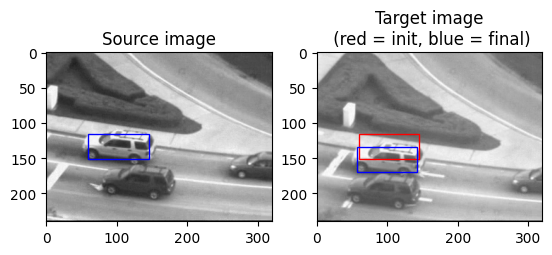

In [5]:
num_iters = 100
threshold = 0.01
seq = np.load("/content/carseq.npy")
rect = [59, 116, 145, 151]
It = seq[:,:,0]

# Source frame
plt.figure()
plt.subplot(1,2,1)
plt.imshow(It, cmap='gray')
plt.title('Source image')
draw_rect(rect,'b')

# Target frame + LK
It1  = seq[:,:, 20]
plt.subplot(1,2,2)
plt.imshow(It1, cmap='gray')
plt.title('Target image\n (red = init, blue = final)')
p = LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2))
rect_t1 = rect + np.concatenate((p,p))
draw_rect(rect,'r')
draw_rect(rect_t1,'b')


## Q2.3: Tracking with template update (15 points)

In [12]:
def TrackSequence(seq, rect, num_iters, threshold):
    """
    :param seq       : (H, W, T), sequence of frames
    :param rect      : (4, 1), coordinates of template in the initial frame. top-left and bottom-right corners.
    :param num_iters : int, number of iterations for running the optimization
    :param threshold : float, threshold for terminating the LK optimization
    :return: rects   : (T, 4) tracked rectangles for each frame
    """
    H, W, N = seq.shape

    rects =[]
    It = seq[:,:,0]

    # Iterate over the car sequence and track the car
    for i in range(seq.shape[2]):

        # ===== your code here! =====
        # TODO: add your code track the object of interest in the sequence
        if i == 0:
            current_rect = np.array(rect).flatten()
            rects.append(current_rect.copy())
        else:
            It_prev = seq[:, :, i-1]
            It_curr = seq[:, :, i]
            p = LucasKanade(It_prev, It_curr, current_rect, threshold, num_iters, p0=np.zeros(2))
            current_rect = current_rect + np.array([p[0], p[1], p[0], p[1]])
            rects.append(current_rect.copy())
        # ===== End of code =====

    rects = np.array(rects)
    assert rects.shape == (N, 4), f"Your output sequence {rects.shape} is not ({N}x{4})"
    return rects

### Q2.3 (a) - Track Car Sequence

Run the following snippets. If you have implemented LucasKanade and TrackSequence function correctly, you should see the box tracking the car accurately. Please note that the tracking might drift slightly towards the end, and that is entirely normal.

Feel free to play with these snippets of code by playing with the parameters.

In [13]:
def visualize_track(seq,rects,frames):
    # Visualize tracks on an image sequence for a select number of frames
    plt.figure(figsize=(15,15))
    for i in range(len(frames)):
        idx = frames[i]
        frame = seq[:, :, idx]
        plt.subplot(1,len(frames),i+1)
        plt.imshow(frame, cmap='gray')
        plt.axis('off')
        draw_rect(rects[idx],'b');

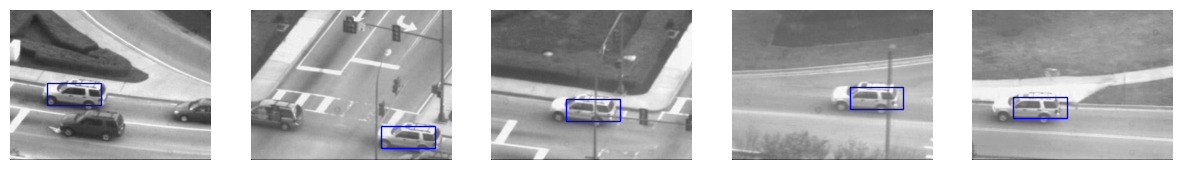

In [14]:
seq = np.load("/content/carseq.npy")
rect = [59, 116, 145, 151]

# NOTE: feel free to play with these parameters
num_iters = 10000
threshold = 0.01

rects = TrackSequence(seq, rect, num_iters, threshold)

visualize_track(seq,rects,[0, 79, 159, 279, 409])

### Q2.3 (b) - Track Girl Sequence

Same as the car sequence.

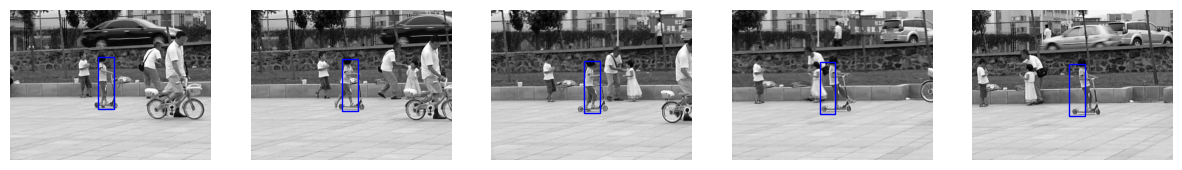

In [15]:
# Loads the squence
seq = np.load("/content/girlseq.npy")
rect = [280, 152, 330, 318]

# NOTE: feel free to play with these parameters
num_iters = 10000
threshold = 0.01

rects = TrackSequence(seq, rect, num_iters, threshold)

visualize_track(seq,rects,[0, 14, 34, 64, 84])